In [1]:
import math

%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import SVI
from pyro.optim import Adam
from pyro.params import param_with_module_name
from pyro.util import ng_ones, ng_zeros

In [2]:
class RBFKernel(nn.Module):
    def __init__(self, variance=torch.ones(1), lengthscale=torch.ones(1)):
        super(RBFKernel, self).__init__()
        self.variance_unconstrained = nn.Parameter(torch.log(variance.exp() - 1))
        self.lengthscale_unconstrained = nn.Parameter(torch.log(lengthscale.exp() - 1))
    
    def forward(self, x, z=None):
        if z is None:
            z = x
        lengthscale = F.softplus(self.lengthscale_unconstrained)
        x = x / lengthscale
        z = z / lengthscale
        xz = x.ger(z)
        xx = x.unsqueeze(1) ** 2
        zz = z.unsqueeze(0) ** 2
        k = F.softplus(self.variance_unconstrained) * torch.exp(-0.5 * (xx - 2*xz + zz))
        return k
    
    def K(self, X, Z=None):
        return self(X, Z)

In [3]:
class MultivariateNormalTriL(dist.Distribution):
    reparameterized = True
    
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
        super(MultivariateNormalTriL, self).__init__()

    def batch_shape(self, x=None):
        event_dim = 1
        loc = self.loc
        if x is not None:
            loc = self.loc.expand_as(x)
        return loc.size()[:-event_dim]

    def event_shape(self):
        event_dim = 1
        return self.loc.size()[-event_dim:]

    def sample(self):
        eps = Variable(torch.randn(self.loc.size()))
        z = self.loc + self.scale.matmul(eps)
        return z if self.reparameterized else z.detach()

    def batch_log_pdf(self, x):
        log_Z = (0.5 * self.loc.size(0) * Variable(torch.Tensor([2*math.pi])).log()
                 + self.scale.diag().log().sum())
        y = self.scale.inverse().matmul(x - self.loc)
        return -0.5 * y.pow(2).sum() - log_Z

In [4]:
class GPRegressor(nn.Module):
    def __init__(self, X, y, kernel, priors={}, noise=0.01, jitter_level=1e-4):
        super(GPRegressor, self).__init__()
        self.X = X
        self.y = y
        self.N = self.X.size(0)
        self.kernel = kernel
        self.priors = priors
        self.noise = ng_ones(1) * noise
        self.jitter_level = ng_ones(1) * jitter_level
        pyro.clear_param_store()
        
    def model(self):
        kernel_fn = pyro.random_module("kernel", self.kernel, self.priors)
        kernel = kernel_fn()
        K = kernel.K(self.X) + Variable(torch.eye(self.N)) * self.jitter_level
        L = K.potrf(upper=False)
        f = pyro.sample("f", MultivariateNormalTriL(ng_zeros(self.N), L), obs=self.y)
        
    def guide(self):
        guide_priors = {}
        for p in self.priors:
            p_MAP_name = param_with_module_name("kernel", p) + "_MAP"
            p_MAP = pyro.param(p_MAP_name,
                               Variable(self.priors[p].analytic_mean(), requires_grad=True))
            guide_priors[p] = dist.Delta(p_MAP)
        kernel_fn = pyro.random_module("kernel", self.kernel, guide_priors)
        kernel = kernel_fn()
        return kernel
        
    def fit(self, lr=0.001, n_iter=1000):
        pyro.clear_param_store()
        optim = Adam({"lr": lr})
        svi = SVI(self.model, self.guide, optim, loss="ELBO", trace_graph=True)
        losses = []
        for i in range(n_iter):
            losses.append(svi.step())
        return losses
    
    def forward(self, Z):
        kernel = self.guide()
        K = kernel.K(self.X) + self.noise.repeat(self.N).diag()
        K_xz = kernel(self.X, Z)
        K_zx = K_xz.t()
        K_zz = kernel.K(Z)
        loc = K_zx.matmul(self.y.gesv(K)[0]).squeeze(1)
        scale = K_zz - K_zx.matmul(K_xz.gesv(K)[0])
        return loc, scale

In [5]:
def plot(model, n_sample=10):
    Z = Variable(torch.linspace(0, 5, 100), volatile=True)
    mean, cov = model(Z)
    sd = cov.diag().sqrt()
    plt.figure(figsize=(12, 6))
    plt.plot(model.X.data.numpy(), model.y.data.numpy(), 'kx', mew=2)
    plt.plot(Z.data.numpy(), mean.data.numpy(), 'C0', lw=2)
    plt.fill_between(Z.data.numpy(),
                     mean.data.numpy() - 2*sd.data.numpy(),
                     mean.data.numpy() + 2*sd.data.numpy(),
                     color='C0', alpha=0.2)
    if n_sample > 0:
        cov = cov + model.jitter_level.repeat(cov.size(0)).diag()
        L = cov.potrf(upper=False)
        d = MultivariateNormalTriL(mean, L)
        for _ in range(n_sample):
            u = d()
            y = dist.Normal(u, model.noise.repeat(u.size(0)))
            plt.plot(Z.data.numpy(), u.data.numpy(), 'C0', lw=2, alpha=0.1)
    plt.xlim(0, 5)
    plt.ylim(-2, 2)

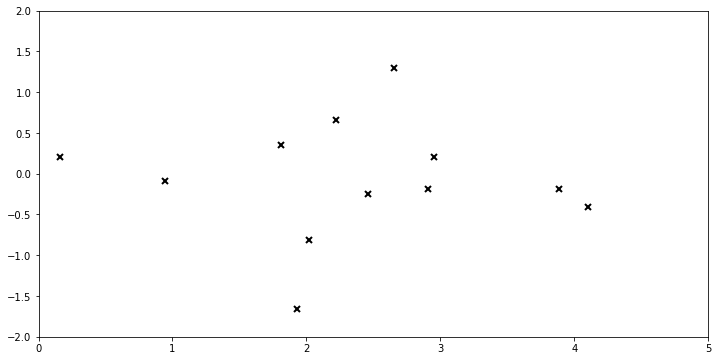

In [6]:
N = 12
X = dist.Uniform(ng_zeros(N), ng_ones(N)*5).sample()
y = 0.5 * torch.sin(3*X) + dist.Normal(ng_zeros(N), ng_ones(N)*0.5).sample()
plt.figure(figsize=(12, 6))
plt.plot(X.data.numpy(), y.data.numpy(), 'kx', mew=2)
plt.xlim(0, 5)
plt.ylim(-2, 2);

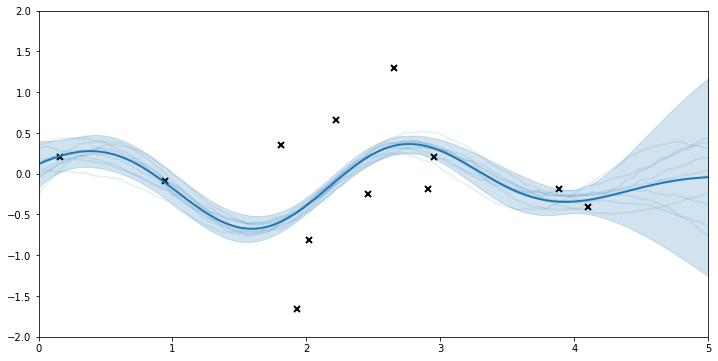

In [7]:
kernel = RBFKernel()
model = GPRegressor(X, y, kernel)
plot(model)

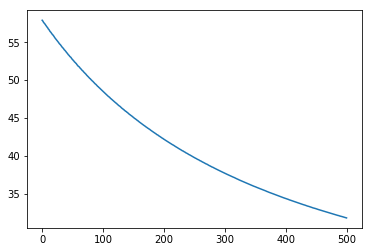

In [8]:
losses = model.fit(lr=0.01)
plt.plot(losses[-500:])

In [9]:
pyro.get_param_store().named_parameters()

dict_items([('kernel$$$lengthscale_unconstrained', Parameter containing:
-1.4537
[torch.FloatTensor of size 1]
), ('kernel$$$variance_unconstrained', Parameter containing:
 2.4596
[torch.FloatTensor of size 1]
)])

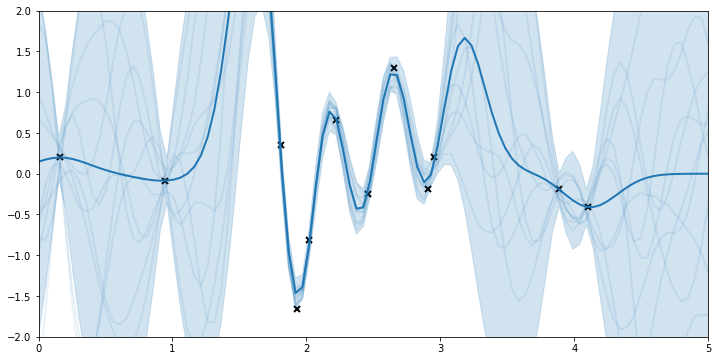

In [10]:
plot(model)